# Optimization Of Algo Case 2

Case 2: Instead of choosing stocks every day bases on some look back and holdin them for some n days; We now choose stocks at day I, hold for N days then close out, and buy new stocks at day I+N. The method of stock choosing is the same.

- Maximize Total Return from 2015-Now
- Minimize Sharpe Ratio: Avg Daily Return - Risk Free Rate(0.05) / STDEV(Daily Return)

- Paramters: 
    - Number of Stocks(NumStocks) int between (2,30)
    - How long to hold the stock(holdTime) int between (0,2)
    - Stop Loss float between (-0.01,-0.05)
    - How long to calculate the Percent Change from int between(2,7)

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pandas_market_calendars as mcal
import datetime
from Tools.Trade_Functions import *
import numpy as np
import mlflow
import optuna

/Users/atulkrishnan/Desktop/TradingAlgos/Stock_Picker_Algo


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
experiment_counter=0
mlflow.set_experiment("Momentum Rider Tuning:V4")
framedCal= get_calendar()

In [12]:
cal=list()
DateRange = [None,None]
for i in range(0,len(framedCal),4+1):
    if DateRange[0]==None and framedCal[i].startswith(str(2015)) :
        DateRange[0]=framedCal[i]
    if framedCal[i].startswith(str(2024)):
        DateRange[1]=framedCal[i]
    cal.append(framedCal[i])

In [13]:
DateRange

['2015-01-07', '2024-11-13']

In [7]:
def objective(trial):
    global experiment_counter
    expirement_name = f"Expirement {experiment_counter}"
    
    with mlflow.start_run(run_name=expirement_name) as run:
        #Setup Paramter Variation
        
        TimeInput = trial.suggest_int('TimeInput', 2, 7)
        NumStocks= trial.suggest_int('NumStocks', 1, 15)
        holdTime=trial.suggest_int('holdTime', 1, 8)
        stopLoss=trial.suggest_float('stopLoss',-0.05, -0.01)
        numDaysToCheckStopLoss= trial.suggest_int('numDaysToCheckStopLoss', 1, holdTime)#must be less than holdtime
        TradeData=pd.DataFrame()
        
        
        
        #Date Range
        cal=list()
        DateRange = [None,None]
        for i in range(0,len(framedCal),holdTime+1):
            if DateRange[0]==None and framedCal[i].startswith(str(2015)):
                DateRange[0]=framedCal[i]
            if framedCal[i].startswith(str(2024)):
                DateRange[1]=framedCal[i]
            cal.append(framedCal[i])
        DateRange=[cal.index(DateRange[0]),cal.index(DateRange[1])]
        TotalReturnList=list()
        

        #Run Algorithim
        for day in cal[DateRange[0]:DateRange[1]]:
            dailyReturn,TradeData = pick_trade(TradeData,RunDate=day,NumStocks=NumStocks,stopLoss=stopLoss,TimeInput=TimeInput,holdTime=holdTime,debug=False,numDaysToCheckStopLoss=numDaysToCheckStopLoss)
            TotalReturnList.append(dailyReturn)
        TradeData=TradeData.reset_index(drop=True)
        returnDf = pd.DataFrame({'Date': pd.to_datetime(cal[DateRange[0]:DateRange[1]]),'Return':TotalReturnList})

        #Compound Retruns
        M = 1
        returnVal=[]
        for i in returnDf["Return"]:
            M = M*(1+i)
            returnVal.append(M)
        returnDf=pd.concat([returnDf,pd.DataFrame({"ReturnVals":returnVal})],axis=1)

        #Calculate Metrics
        SharpeRatio =(np.mean(returnDf["Return"]) * 252 - 0.05) / (np.std(returnDf["Return"]) * np.sqrt(252))
        CumulativeReturn = returnDf.loc[len(returnDf)-1,"ReturnVals"]
        max_drawdown = calculate_mdd(returnDf["Return"])
        sortino_ratio = calculate_sortino_ratio(returnDf["Return"])


        pLratio = len(returnDf["Return"][returnDf["Return"]>0])/ len(returnDf["Return"])

        avg_loss= np.mean(returnDf["Return"][returnDf["Return"]<0])
        avg_prof= np.mean(returnDf["Return"][returnDf["Return"]>0])
        


        #Saving A plot
        plt.figure(figsize=(15, 6))  # Set the figure size
        plt.plot(returnDf['Date'], returnDf['ReturnVals'],  linestyle='-', color='blue', label="Return Vals")
        plt.title("Return Values Over Time", fontsize=16)
        plt.xlabel("Date", fontsize=12)
        plt.ylabel("Return Vals", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=12)
        plt.tight_layout()
        plt.savefig("returns.png", dpi=300, bbox_inches='tight')
        plt.close()
        #LOG Paramters, Metrics and Artifacts

        mlflow.log_param("TimeInput", trial.params['TimeInput'])
        mlflow.log_param("NumStocks", trial.params['NumStocks'])
        mlflow.log_param("holdTime", trial.params['holdTime'])
        mlflow.log_param("stopLoss", trial.params['stopLoss'])
        mlflow.log_param("numDaysToCheckStopLoss", trial.params['numDaysToCheckStopLoss'])

        
        mlflow.log_metric("CumulativeReturn", CumulativeReturn)
        mlflow.log_metric("SharpeRatio", SharpeRatio)
        mlflow.log_metric("Profit_Loss_Ratio", pLratio)
        mlflow.log_metric("avg_prof",avg_prof)
        mlflow.log_metric("avg_loss", avg_loss)
        
        mlflow.log_metric("Max_Draw_Down",max_drawdown)
        mlflow.log_metric("sortino_ratio",sortino_ratio)

        
        yearly_plots(returnDf)
        
        mlflow.log_artifact("Visulizations/returns.png", artifact_path="Visulizations")
        
        
        yearlyReturns=list()
        years=range(2015,2025)

        for year in range(2015,2025):
            returnDf_year = returnDf[returnDf['Date'].dt.year == year]
            returnDf_year.loc[:, 'Return'] = returnDf_year['Return'].astype(float)
            yearlyReturns.append(np.prod(1 + returnDf_year['Return']))
            mlflow.log_artifact(f"Visulizations/returns_{year}.png", artifact_path="Visulizations")
         
        plt.figure(figsize=(10, 6))
        plt.plot(years, yearlyReturns, marker='o', linestyle='-', color='blue', label='Annual Returns')

        # Add numeric values above each point
        for i, value in enumerate(yearlyReturns):
            plt.text(years[i], value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

        # Add labels, title, and grid
        plt.title("Annual Returns (2015-2024)", fontsize=16)
        plt.xlabel("Year", fontsize=12)
        plt.ylabel("Return Value", fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(fontsize=12)
        plt.tight_layout()
        # Save the plot as PNG
        plt.savefig("Visulizations/annual_returns.png", dpi=300)
        
        mlflow.log_artifact("Visulizations/annual_returns.png", artifact_path="Visulizations")
        
        TradeData.to_csv("Visulizations/TradeData.csv")
        returnDf.to_csv("Visulizations/Returns.csv")
        mlflow.log_artifact("Visulizations/TradeData.csv", artifact_path="Generated_Data")
        mlflow.log_artifact("Visulizations/Returns.csv", artifact_path="Generated_Data")


    

            
        experiment_counter += 1
        
        return CumulativeReturn, SharpeRatio, sortino_ratio, max_drawdown

[I 2024-11-28 21:16:10,386] A new study created in memory with name: no-name-197fe91e-c4a0-4b82-91bc-9aedee585108
[I 2024-11-28 21:16:17,754] Trial 0 finished with values: [0.001494042286160465, -6.783345328635645, -0.7075912959596131, -0.9985220731122685] and parameters: {'TimeInput': 7, 'NumStocks': 10, 'holdTime': 1, 'stopLoss': -0.016421089683992002, 'numDaysToCheckStopLoss': 1}.
[I 2024-11-28 21:16:24,269] Trial 1 finished with values: [0.0016840708751010918, -5.723364905606811, -0.5627561865087534, -0.998333531558774] and parameters: {'TimeInput': 3, 'NumStocks': 6, 'holdTime': 2, 'stopLoss': -0.028712558501724723, 'numDaysToCheckStopLoss': 2}.
[I 2024-11-28 21:16:30,148] Trial 2 finished with values: [0.03423444154089412, -4.776611617291829, -0.4253093728034054, -0.9663889677155701] and parameters: {'TimeInput': 3, 'NumStocks': 11, 'holdTime': 4, 'stopLoss': -0.04484157836987501, 'numDaysToCheckStopLoss': 1}.
[I 2024-11-28 21:16:36,063] Trial 3 finished with values: [0.040571811

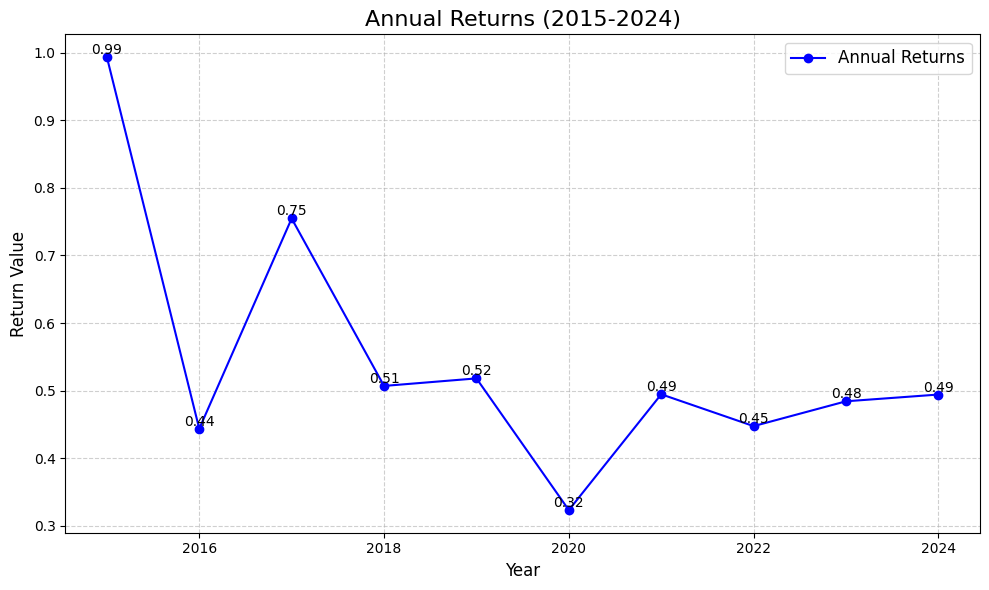

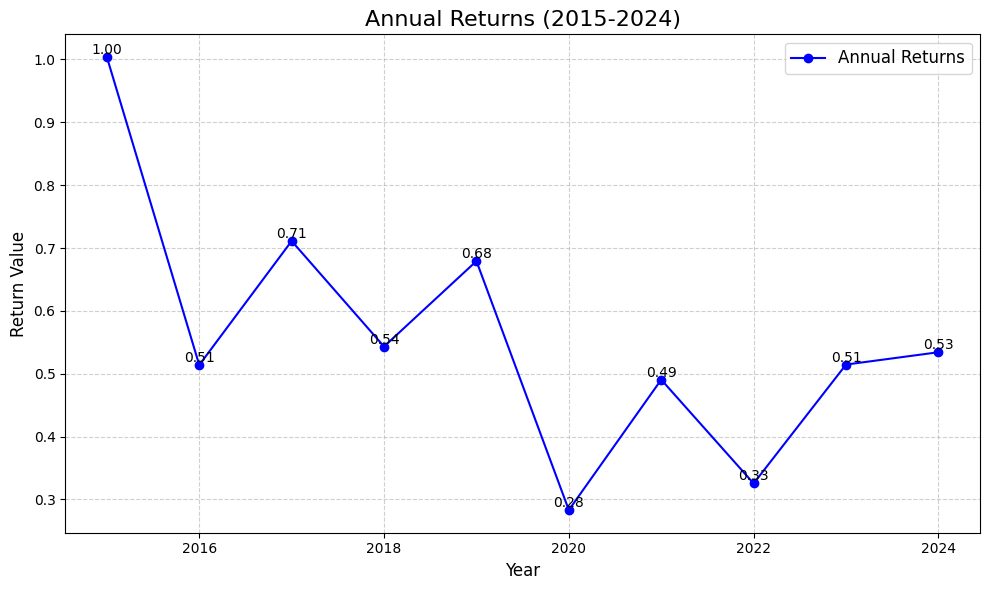

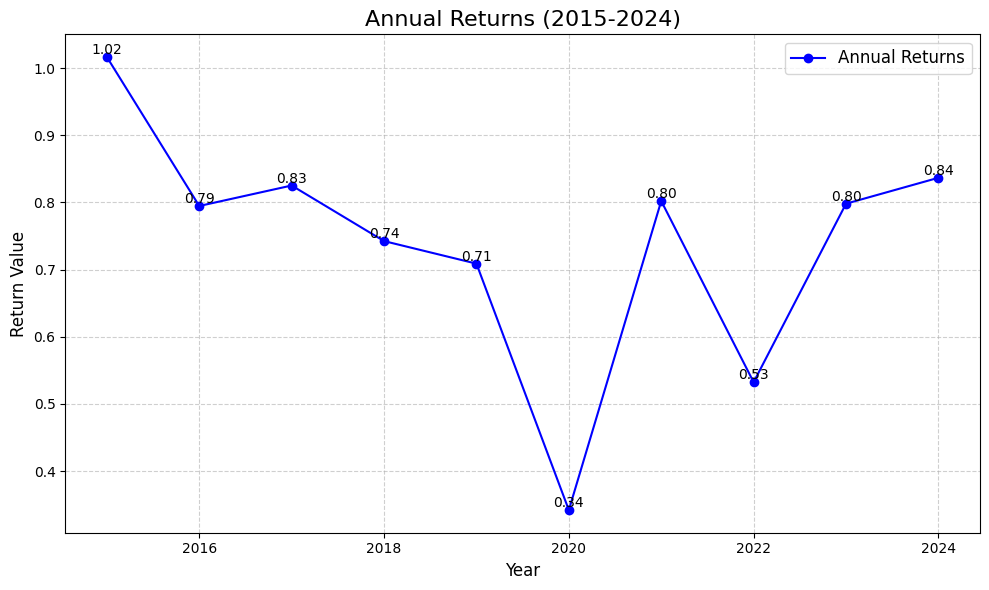

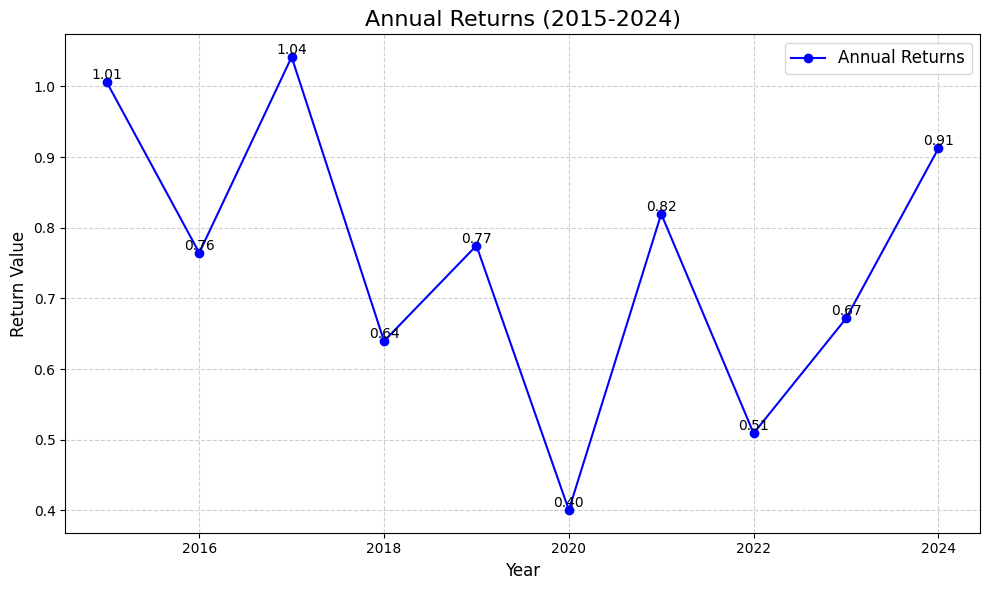

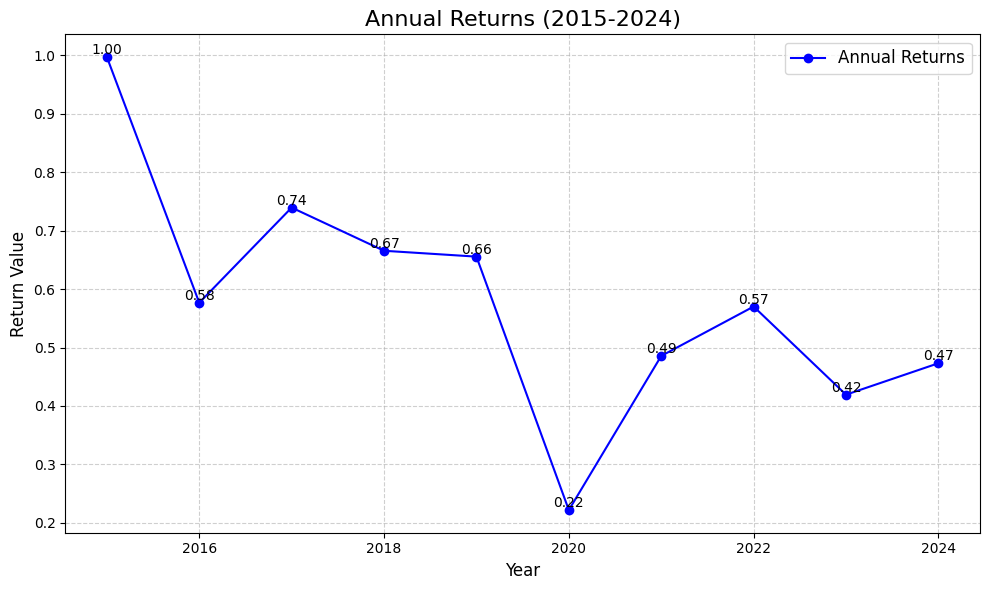

In [8]:
study = optuna.create_study(directions=["maximize","maximize","maximize","minimize"])
study.optimize(objective, n_trials=5)